In [1]:
import cv2
import os
import numpy as np 
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,GroupKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import timm
import torchmetrics
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as PL
from torch.utils.data.dataloader import DataLoader,Dataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import  ReduceLROnPlateau,CosineAnnealingWarmRestarts,CosineAnnealingLR
from pytorch_lightning import seed_everything, LightningModule, Trainer


In [2]:
#images are chosed randomly

In [3]:
import pandas as pd

dutch_train_df=pd.read_csv('../csv/dutch.csv')
chinese_train_df=pd.read_csv('../csv/chinese.csv')
all_df=pd.read_csv('../csv/all_data.csv')
#train_df=dutch_train_df
dutch_test_df=pd.read_csv('../csv/test_dutch.csv')
chinese_test_df=pd.read_csv('../csv/test_chinese.csv')

train_df=pd.concat([dutch_train_df,chinese_train_df,all_df,dutch_test_df,chinese_test_df])

test_df=pd.read_csv('../csv/test_data.csv')

# test_df=pd.concat([dutch_test_df,chinese_test_df])
#test_df=dutch_test_df
print('train',len(train_df))
print('test',len(test_df))

train_df.head()
#real id:writer
#real_idx: attempt

train 391381
test 750


,real_path,real_label,real_id,real_idx,forged_path,forged_label,forged_id,forged_idx,data
0,../../SiameseData/ICDAR2011/trainingSet/Offlin...,real,1,1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,forge,1,1,dutch
1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,real,1,1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,forge,1,2,dutch
2,../../SiameseData/ICDAR2011/trainingSet/Offlin...,real,1,1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,forge,1,3,dutch
3,../../SiameseData/ICDAR2011/trainingSet/Offlin...,real,1,1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,forge,1,4,dutch
4,../../SiameseData/ICDAR2011/trainingSet/Offlin...,real,1,1,../../SiameseData/ICDAR2011/trainingSet/Offlin...,forge,1,1,dutch


In [4]:
train_df_real=train_df[['real_path','data','real_id']].drop_duplicates().reset_index(drop=True)
train_df_forged=train_df[['forged_path','data','forged_id']].drop_duplicates().reset_index(drop=True)
len(train_df_real),len(train_df_forged)

(12888, 16041)

In [5]:
test_df_real=test_df[['real_path','data','real_id']].drop_duplicates().reset_index(drop=True)
test_df_forged=test_df[['forged_path','data','forged_id']].drop_duplicates().reset_index(drop=True)
len(test_df_real),len(test_df_forged)

(150, 150)

In [6]:
from albumentations.core.transforms_interface import DualTransform
class Erode(DualTransform):

    def apply(self, img, **params):
        return cv2.erode(img, np.ones((3, 3), np.uint8)) 

class Dilate(DualTransform):

    def apply(self, img, **params):
        return cv2.dilate(img, np.ones((3, 3), np.uint8)) 

In [7]:
img_size=224
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_aug= A.Compose([
            A.Resize(img_size+32,img_size+32),
            A.RandomCrop(img_size,img_size),
            Erode(p=0.5),
            A.ShiftScaleRotate(rotate_limit=10,p=0.5),
            A.Cutout(8,4,4),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
#         additional_targets={'image0': 'image'}
        )
test_aug= A.Compose([
            A.Resize(img_size,img_size),
            ToTensorV2(p=1.0),
        ], 
        p=1.0,
#         additional_targets={'image0': 'image'}
        )

/home/talha/torchenv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [8]:
class SiameseNetworkDataset():
    
    def __init__(self,real,fake,transform=None):
        self.real = real    
        self.fake = fake    
        self.transform=transform
        

    def __getitem__(self,index):
        img0 = self.real.iloc[index]
        #we need to make sure approx 50% of images are in the same class
        same_class = random.randint(0,1) 
        
        if same_class:
            img1=self.real[(self.real.real_id==img0.real_id) & (self.real.data==img0.data)]
            index_1 = random.randint(0, len(img1)-1)
            img1=img1.iloc[index_1] #choose another image of same id
            img0p=img0.real_path
            img1p=img1.real_path
#             print('real',img0.real_id,img1.real_id,img0.data,img1.data)
            label=torch.zeros(1).long()#images are real from same author
        else:
            img1=self.fake[(self.fake.forged_id==img0.real_id) & (self.fake.data==img0.data)]#get subset of same id but from forged
            index_1 = random.randint(0, len(img1)-1)
            img1=img1.iloc[index_1]
            img0p=img0.real_path
            img1p=img1.forged_path
            label=torch.ones(1).long()
#             print('forged',img0.real_id,img1.forged_id,img0.data,img1.data)
        img0 = np.array(Image.open(img0p).convert("L"))
        img1 = np.array(Image.open(img1p).convert("L"))
        
        img0=self.transform(image=img0)['image']/255
        img1=self.transform(image=img1)['image']/255
        

        return img0, img1 ,label
    
    def __len__(self):
        return len(self.real)

In [9]:
sample_reader=SiameseNetworkDataset(train_df_real,train_df_forged,train_aug);    
sample_loader = DataLoader(sample_reader,shuffle=False,num_workers=0,batch_size=4)
batch=next(iter(sample_loader));
print(batch[0].shape,batch[1].shape)

torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])


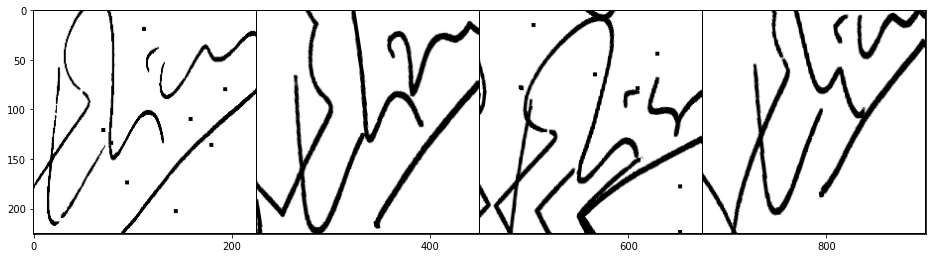

In [10]:
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(batch[0],4,1)
plt.imshow(grid_img.permute(1, 2, 0))

In [11]:
sample_reader=SiameseNetworkDataset(train_df_real,train_df_forged,test_aug);    
sample_loader = DataLoader(sample_reader,shuffle=False,num_workers=2,batch_size=4)
batch=next(iter(sample_loader));
print(batch[0].shape,batch[1].shape)

torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])


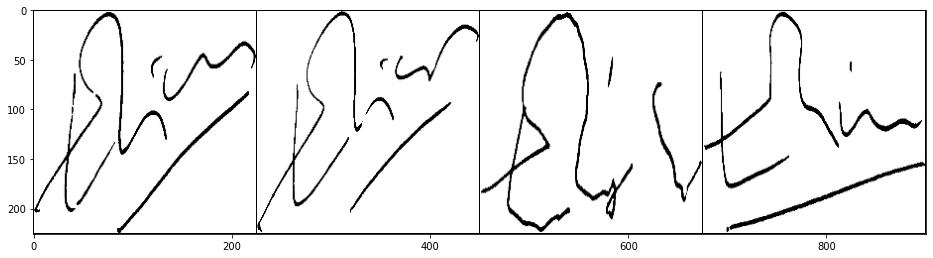

In [12]:
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(batch[1],4,1)
plt.imshow(grid_img.permute(1, 2, 0))

In [13]:
import torch
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, distance, label):
        loss_contrastive = torch.mean((1-label) * torch.pow(distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))

        return loss_contrastive
    
class EuclideanDistance(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(EuclideanDistance, self).__init__()

    def forward(self, output1, output2):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2, keepdim = True)
        return euclidean_distance

In [14]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        # model architecute
        
        self.model =  timm.create_model('mobilenetv3_rw',pretrained=True)
        self.model.conv_stem=nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)#mobile
        self.model.classifier=nn.Sequential(
                              nn.Linear(1280,512),#1536
                              nn.BatchNorm1d(512),
                              nn.ReLU(),
                              nn.Dropout(0.25),
                              nn.Linear(512,256),
                                nn.BatchNorm1d(256),
                              nn.ReLU(),
                              nn.Dropout(0.25),
                              nn.Linear(256,128),
                        )
        self.distancelayer=EuclideanDistance()
        #parameters
        self.lr=1e-3
        self.batch_size=72
        self.numworker=4
        self.criterion=ContrastiveLoss() #loss function
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self,x1,x2):
        x1= self.model(x1)
        x2= self.model(x2)
        x=self.distancelayer(x1,x2)
        return x

    
    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        scheduler=CosineAnnealingLR(opt,T_max=5,  eta_min=1e-6, last_epoch=-1)
        return {'optimizer': opt,'lr_scheduler':scheduler}
    
    def train_dataloader(self):#load train 
        return DataLoader(SiameseNetworkDataset(train_df_real,train_df_forged,\
                                                     train_aug),shuffle=True,num_workers=self.numworker,
                          batch_size=self.batch_size)

    def training_step(self,batch,batch_idx):
        image0,image1,label=batch
        out = self(image0,image1)#pass images to model
        loss=self.criterion(out,label) #calculate loss
        acc=self.accuracy(out,label)
        
        self.log("train_loss", loss, on_step=False,prog_bar=True, on_epoch=True)
        self.log("train_acc", acc, on_step=False,prog_bar=True, on_epoch=True)
        return loss  # Return tensor to call ".backward" on

        
    def val_dataloader(self):
        ds=DataLoader(SiameseNetworkDataset(test_df_real,test_df_forged,
                                            test_aug),shuffle=False,num_workers=self.numworker,
                      batch_size=self.batch_size)
        return ds

    def validation_step(self,batch,batch_idx):
        image0,image1,label=batch
        out = self(image0,image1)#pass images to model
        loss=self.criterion(out,label) #calculate loss
        acc=self.accuracy(out,label)
        self.log("val_loss", loss, on_step=False,prog_bar=True, on_epoch=True)
        self.log("val_acc", acc, on_step=False,prog_bar=True, on_epoch=True)
        return loss  # Return tensor to call ".backward" on


In [15]:
!ls lightning_logs/version_3/checkpoints

ls: cannot access 'lightning_logs/version_3/checkpoints': No such file or directory


In [16]:
model=OurModel()
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = Trainer(max_epochs=30,
                    deterministic=True,
                    gpus=-1,precision=16,
                    accumulate_grad_batches=4,
                    progress_bar_refresh_rate=10,
                    callbacks=[lr_monitor],
                    num_sanity_val_steps=0,
                  #resume_from_checkpoint='lightning_logs/version_3/checkpoints/epoch=29-step=2039.ckpt'
                    )

Using 16bit native Automatic Mixed Precision (AMP)
/home/talha/torchenv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | model         | MobileNetV3       | 5.0 M 
1 | distancelayer | EuclideanDistance | 0     
2 | criterion     | ContrastiveLoss   | 0     
3 | accuracy      | Accuracy          | 0     
----------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
10.041    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [18]:
torch.save(model.model.state_dict(), '../models/siamesenet.pt')

In [19]:
input_sample = torch.randn((1,1, img_size,img_size))

torch.onnx.export(model.model.cpu(),               # model being run
                  input_sample,                         # model input (or a tuple for multiple inputs)
                  "../models/mobilenetv3_rw.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=14,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  )

In [20]:
!ls ../models

mobilenet.pt	      mobilenetv3_rw.onnx	   siamesenet.pt
mobilenet_t0.75.onnx  siamesemodel_large_100.onnx


In [21]:
import onnxruntime
from PIL import Image
import timm
import torch.nn as nn
import torch

ort_session = onnxruntime.InferenceSession('../models/mobilenetv3_rw.onnx')

In [22]:
def getembs(img1,img2):
    inp1 = {ort_session.get_inputs()[0].name: img1}
    emb1= ort_session.run(None, inp1)[0]
    inp2 = {ort_session.get_inputs()[0].name: img2}
    emb2= ort_session.run(None, inp2)[0]
    return emb1.ravel(),emb2.ravel()
from decimal import Decimal
def p_root(value, root):
     
    root_value = 1 / float(root)
    return round (Decimal(value) **
             Decimal(root_value), 3)
def minkowski_distance(x, y, p_value=2):
    return float(p_root(sum(pow(abs(a-b), p_value)
            for a, b in zip(x, y)), p_value))

In [23]:
testloader=model.test_dataloader()
test_image1,test_image2,test_labels=[],[],[]
for batch in testloader:
    img1,img2,label=batch
    img1,img2,label=img1.numpy(),img2.numpy(),label.numpy()
    test_image1.append(img1)
    test_image2.append(img2)
    test_labels.append(label)
    

In [24]:
test_image1=np.concatenate(test_image1)
test_image2=np.concatenate(test_image2)
test_labels=np.concatenate(test_labels)

In [25]:
true,pred=[],[]
for idx in range(len(test_labels)):
    img1x,img2x,labelx=np.expand_dims(test_image1[idx],0),np.expand_dims(test_image2[idx],0),test_labels[idx]
    emb1,emb2=getembs(img1x,img2x)
    pred.append(minkowski_distance(emb1,emb2))
    true.append(int(labelx))

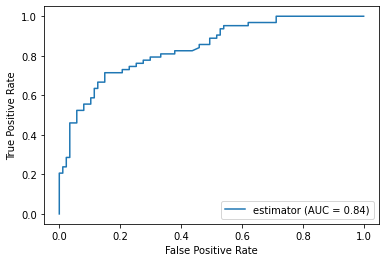

In [26]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='estimator')
display.plot()

plt.show()

In [27]:
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.397000, G-Mean=0.779


In [28]:
print(metrics.classification_report(true, np.where(np.array(pred)>thresholds[ix],1,0)))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        87
           1       0.77      0.70      0.73        63

    accuracy                           0.79       150
   macro avg       0.78      0.77      0.78       150
weighted avg       0.79      0.79      0.78       150

